In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.sort import natural_sort_key

from DyUNETA import DynamicAttentionUNET
device = torch.device('cuda')

In [2]:
# Load model
model = torch.load('dyuneta_200epoch.pth')
model = model.to(device)  # Ensure it is moved to the correct device
# model = DynamicAttentionUNET(1, (4,30,6)).to(device)
# model.load_state_dict(torch.load('dyuneta_50epoch.pth'))

ground truth data shape: (17, 64, 64)
predicted data shape: (1, 17, 64, 64)


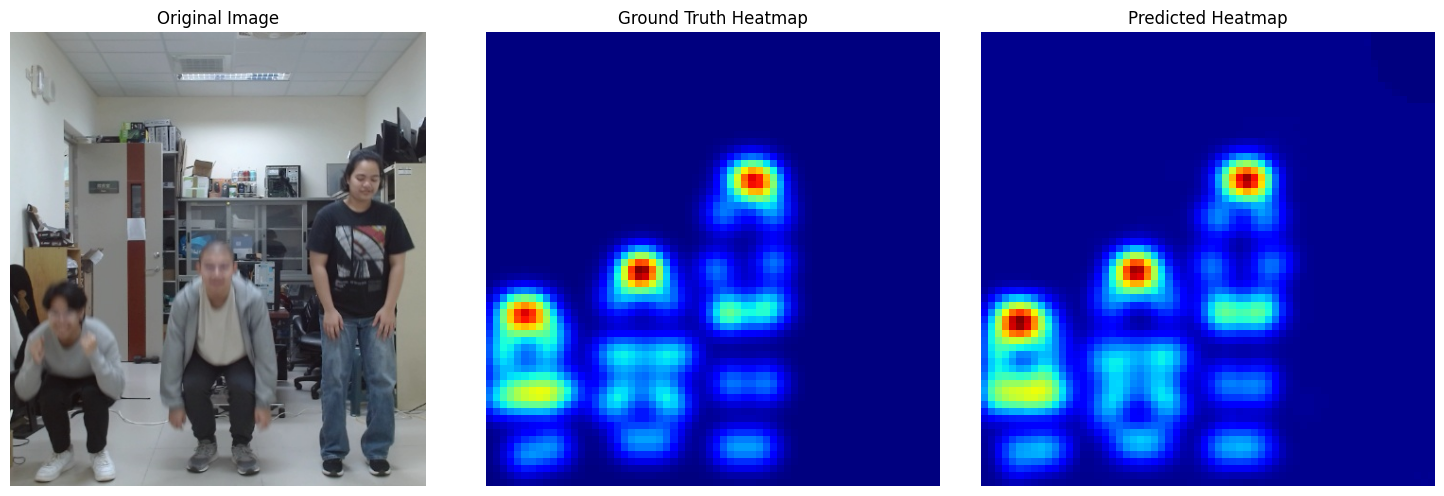

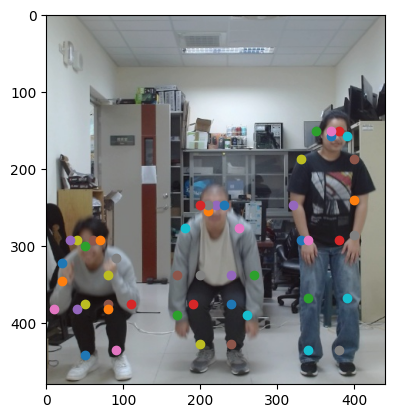

In [68]:
# ground truth
import random
rand_num = random.randint(0, 564)
test_path = f'../multi-person-data/JHM/G7/A2/frame{rand_num}.npy'
gt_data = np.load(test_path)
gt_image = plt.imread(test_path.replace('JHM', 'photo_rename').replace('npy', 'jpg'))
print('ground truth data shape:', gt_data.shape)

# Predict
test_data = torch.from_numpy(np.load(test_path.replace('JHM', 'preprocess_csi/30_sub'))).unsqueeze(0).float()
test_output, _ = model(test_data.to(device))
test_output = test_output.detach().cpu().numpy()
print('predicted data shape:',test_output.shape)

# Create figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot original image
axs[0].imshow(gt_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot ground truth heatmap
axs[1].imshow(np.sum(gt_data, axis=0), cmap='jet')
axs[1].set_title('Ground Truth Heatmap')
axs[1].axis('off')

# Plot predicted heatmap
axs[2].imshow(np.sum(test_output[0], axis=0), cmap='jet')
axs[2].set_title('Predicted Heatmap')
axs[2].axis('off')

plt.tight_layout()
plt.show()

# Convert joint heatmap back into keypoint coordinates
import scipy.ndimage as ndi
def detect_multiple_peaks(heatmap, threshold=0.1, neighborhood_size=3):
    """
    Detects multiple local maxima in a heatmap.

    Parameters:
        heatmap (numpy.ndarray): Single joint heatmap of shape [height, width].
        threshold (float): Minimum confidence value for a peak.
        neighborhood_size (int): Size of the neighborhood for detecting peaks.

    Returns:
        peaks (list): List of detected peaks as (x, y, confidence).
    """
    # Apply a threshold to remove low-confidence values
    heatmap[heatmap < threshold] = 0

    # Find local maxima
    max_filtered = ndi.maximum_filter(heatmap, size=neighborhood_size)
    peaks_mask = (heatmap == max_filtered) & (heatmap > 0)

    # Extract coordinates of local maxima
    peaks_coords = np.argwhere(peaks_mask)
    confidences = heatmap[peaks_mask]

    # Convert coordinates and confidence to (x, y, confidence) format
    peaks = [(int(x), int(y), float(conf)) for (y, x), conf in zip(peaks_coords, confidences)]

    return peaks

def heatmap2keypoint(heatmap, img_size, thresh, neighborhood_size):
    num_joint, h, w = heatmap.shape
    keypoints = [[] for _ in range(num_joint)]
    for joint_idx in range(num_joint):
        # extract joint from current heatmap
        joint_heatmap = heatmap[joint_idx]
        
        # Detect all peaks for this joint
        peaks = detect_multiple_peaks(joint_heatmap, thresh, neighborhood_size=neighborhood_size)
        
        # denormalize keypoints coordinates to math with original image size
        for x, y, conf in peaks:
            x = int(x * img_size[0] / w)
            y = int(y * img_size[1] / h)
            keypoints[joint_idx].append((x, y, conf))
    return np.array(keypoints)

# Convert joint heatmap back into keypoint coordinates
gt_keypoints = heatmap2keypoint(gt_data, (640, 480), 0.2, 5)

# Visualize the keypoints
# Plot heatmap with detected peaks
plt.imshow(gt_image)
# Loop through joints and plot keypoints
for joint_idx, joint_keypoints in enumerate(gt_keypoints):
    for x, y, _ in joint_keypoints:
        plt.plot(x, y, 'o')

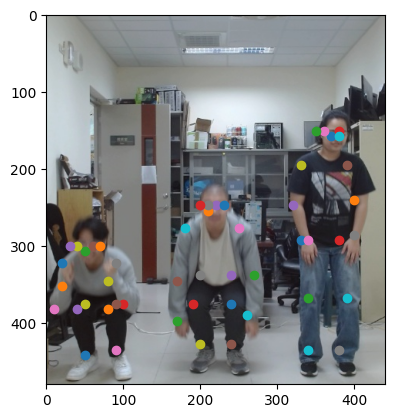

In [69]:
plt.imshow(gt_image)
pred_keypoints = heatmap2keypoint(test_output[0], (640, 480), 0.2, 5)
for joint_idx, joint_keypoints in enumerate(pred_keypoints):
    for x, y, _ in joint_keypoints:
        plt.plot(x, y, 'o')

In [3]:
import cv2
from tqdm import tqdm
# Initialize ground truth data
name = 'G1/A1'
path = f'../multi-person-data/preprocess_csi/30_sub/{name}'
img_path = f'../multi-person-data/photo_rename/{name}'
gt_data_path = f'../multi-person-data/JHM/{name}'
model.eval()

data = torch.empty((4, 30, 0))
files = sorted(os.listdir(path), key=natural_sort_key)
for file in files:
    a = torch.from_numpy(np.load(os.path.join(path, file), allow_pickle=True))
    data = torch.cat((data, a), dim=-1)
# print(data.shape)

# Initialize 
# Initialize video writer (no capture needed)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_size = (440, 480)  # (width, height)
out = cv2.VideoWriter('result.mp4', fourcc, 25, (960, 480))  # width, height


# Prepare parameters
time = 0
frame = 0
real_time_data = []

# Convert data to float32 to match model parameters
heatmap_size = (64, 64)

# Function to merge heatmaps into a single image
def merge_heatmaps(heatmaps):
    merged = np.sum(heatmaps, axis=0)  # Summing all heatmaps
    merged = (merged / merged.max() * 255).astype(np.uint8)  # Normalize and scale
    return cv2.applyColorMap(merged, cv2.COLORMAP_JET)  # Apply a color map

heatmaps = None  # Initialize heatmaps

while time != data.shape[-1]:
    real_time_data.append(data[:, :, time])
    time += 1

    # Prepare input data if we have enough frames
    if len(real_time_data) % 6 != 0:
        continue
    # Get the last 6 frames and Add batch dimension
    input_data = torch.stack(real_time_data[-6:], dim=-1).to(device).unsqueeze(0).float()  # Shape (4, 30, 6) -> Shape (1, 4, 30, 6)

    # print(f"Processing frame {frame}: {input_data.shape}")

    with torch.no_grad():
        pred, _ = model(input_data)  # Shape (1, 17, 64, 64)
    heatmaps = pred.squeeze(0).cpu().detach().numpy()  # Shape (17, 64, 64)

    # Load ground truth image and data
    gt_data = f'{gt_data_path}/frame{frame}.npy'
    gt_image_path = f'{img_path}/frame{frame}.jpg'
    try:
        gt_image = cv2.imread(gt_image_path)
        gt_data = np.load(gt_data)
    except FileNotFoundError:
        print(f"Files not found for frame {frame}. Skipping.")
        continue
    frame += 1
    
    out_frame = np.zeros((*output_size[::-1], 3), dtype=np.uint8)
    # Create visualizations
    gt_heatmap = merge_heatmaps(gt_data)  # Summed ground truth heatmap
    pred_heatmap = merge_heatmaps(heatmaps)  # Summed predicted heatmap

    # Resize images for overlay
    gt_heatmap_resized = cv2.resize(gt_heatmap, output_size)
    gt_heatmap_resized = cv2.addWeighted(out_frame, 0.5, gt_heatmap_resized, 0.5, 0)
    pred_heatmap_resized = cv2.resize(pred_heatmap, output_size)
    pred_heatmap_resized = cv2.addWeighted(out_frame, 0.5, pred_heatmap_resized, 0.5, 0)

    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    axes[0].imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Ground Truth Image')
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(gt_heatmap_resized, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Ground Truth Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(pred_heatmap_resized, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Predicted Heatmap')
    axes[2].axis('off')

    # Save subplot as image
    subplot_image_path = f"predicted/temp_frame_{frame}.png"
    plt.tight_layout()
    plt.savefig(subplot_image_path)
    plt.close(fig)
    
path = 'predicted/'
out_path = 'method04'
out_video_name = f'200epch_{name.replace('/','')}.mp4'

pre_imgs = sorted(os.listdir(path), key=natural_sort_key)
# print(pre_imgs)
img = []

for i in pre_imgs:
    i = path+i
    # print(i)
    img.append(i)

# print(img)

cv2_fourcc = cv2.VideoWriter_fourcc(*'mp4v')

frame = cv2.imread(img[0])
size = list(frame.shape)
del size[2]
size.reverse()
# print(size)

video = cv2.VideoWriter(out_video_name, cv2_fourcc, 25, size) #output video name, fourcc, fps, size

for i in range(len(img)): 
    video.write(cv2.imread(img[i]))
    # print('frame ', i+1, ' of ', len(img))

video.release()
print('outputed video to ', out_path)

# Clean up temporary files
for file in os.listdir(path):  # Remove temporary subplot images
    if file.startswith("temp_frame_") and file.endswith(".png"):
        os.remove(os.path.join(path,file))

outputed video to  method04
